# Gradient Descent and SGD

##### Keywords: optimization, gradient descent, sgd, minibatch sgd,  linear regression

## Contents
{:.no_toc}
* 
{: toc}

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats 

from sklearn.datasets.samples_generator import make_regression 

A lot of the animations here were adapted from: http://tillbergmann.com/blog/python-gradient-descent.html

A great discussion (and where momentum image was stolen from) is at http://sebastianruder.com/optimizing-gradient-descent/

Gradient descent is one of the most popular algorithms to perform optimization and by far the most common way to optimize neural networks. Gradient descent is a way to minimize an objective function $J_{\theta}$ parameterized by a model's parameters $\theta \in \mathbb{R}^d$ by updating the parameters in the opposite direction of the gradient of the objective function $\nabla_J J(\theta)$ w.r.t. to the parameters. The learning rate $\eta$ determines the size of the steps we take to reach a (local) minimum. In other words, we follow the direction of the slope of the surface created by the objective function downhill until we reach a valley.

There are three variants of gradient descent, which differ in how much data we use to compute the gradient of the objective function. Depending on the amount of data, we make a trade-off between the accuracy of the parameter update and the time it takes to perform an update.

## Example: Linear regression

Let's see briefly how gradient descent can be useful to us in least squares regression. Let's asssume we have an output variable $y$ which we think depends linearly on the input vector $x$. We approximate $y$ by

$$f_\theta (x) =\theta^T x$$

The cost function for our linear least squares regression will then be

$$J(\theta) = \frac{1}{2} \sum_{i=1}^m (f_\theta (x^{(i)}-y^{(i)})^2$$


We create a regression problem using sklearn's `make_regression` function:

In [2]:
#code adapted from http://tillbergmann.com/blog/python-gradient-descent.html
x, y = make_regression(n_samples = 100, 
                       n_features=1, 
                       n_informative=1, 
                       noise=20,
                       random_state=2017)

In [3]:
x = x.flatten()

In [4]:
slope, intercept, _,_,_ = stats.linregress(x,y)
best_fit = np.vectorize(lambda x: x * slope + intercept)

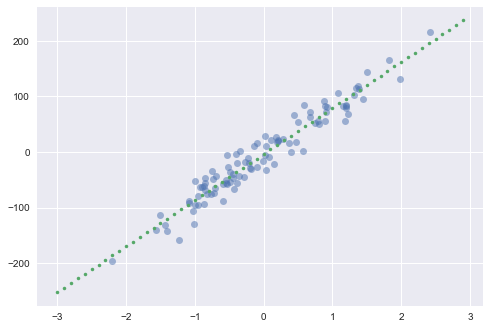

In [5]:
plt.plot(x,y, 'o', alpha=0.5)
grid = np.arange(-3,3,0.1)
plt.plot(grid,best_fit(grid), '.')

## Batch gradient descent

Assume that we have a vector of paramters $\theta$ and a cost function $J(\theta)$ which is simply the variable we want to minimize (our objective function). Typically, we will find that the objective function has the form:

$$J(\theta) =\sum_{i=1}^m J_i(\theta)$$

where $J_i$ is associated with the i-th observation in our data set. The batch gradient descent algorithm, starts with some initial feasible  $\theta$ (which we can either fix or assign randomly) and then repeatedly performs the update:

$$\theta := \theta - \eta \nabla_{\theta} J(\theta) = \theta -\eta \sum_{i=1}^m \nabla J_i(\theta)$$

where $\eta$ is a constant controlling step-size and is called the learning rate. Note that in order to make a single update, we need to calculate the gradient using the entire dataset. This can be very inefficient for large datasets.

In code, batch gradient descent looks like this:

```python
for i in range(n_epochs):
  params_grad = evaluate_gradient(loss_function, data, params)
  params = params - learning_rate * params_grad`
```
  
For a given number of epochs $n_{epochs}$, we first evaluate the gradient vector of the loss function using **ALL** examples in the data set, and then we update the parameters with a given learning rate. This is where Theano and automatic differentiation come in handy, and you will learn about them in lab.

Batch gradient descent is guaranteed to converge to the global minimum for convex error surfaces and to a local minimum for non-convex surfaces.

In the linear example it's easy to see that our update step then takes the form:

$$\theta_j := \theta_j + \alpha \sum_{i=1}^m (y^{(i)}-f_\theta (x^{(i)})) x_j^{(i)}$$
for every $j$ (note $\theta_j$ is simply the j-th component of the $\theta$ vector).


In [6]:
def gradient_descent(x, y, theta_init, step=0.001, maxsteps=0, precision=0.001, ):
    costs = []
    m = y.size # number of data points
    theta = theta_init
    history = [] # to store all thetas
    preds = []
    counter = 0
    oldcost = 0
    pred = np.dot(x, theta)
    error = pred - y 
    currentcost = np.sum(error ** 2) / (2 * m)
    preds.append(pred)
    costs.append(currentcost)
    history.append(theta)
    counter+=1
    while abs(currentcost - oldcost) > precision:
        oldcost=currentcost
        gradient = x.T.dot(error)/m 
        theta = theta - step * gradient  # update
        history.append(theta)
        
        pred = np.dot(x, theta)
        error = pred - y 
        currentcost = np.sum(error ** 2) / (2 * m)
        costs.append(currentcost)
        
        if counter % 25 == 0: preds.append(pred)
        counter+=1
        if maxsteps:
            if counter == maxsteps:
                break
        
    return history, costs, preds, counter

In [7]:
np.random.rand(2)

array([ 0.64739517,  0.92593885])

In [8]:
xaug = np.c_[np.ones(x.shape[0]), x]
theta_i = [-15, 40] + np.random.rand(2)
history, cost, preds, iters = gradient_descent(xaug, y, theta_i, step=0.1)
theta = history[-1]

In [9]:
print("Gradient Descent: {:.2f}, {:.2f} {:d}".format(theta[0], theta[1], iters))
print("Least Squares: {:.2f}, {:.2f}".format(intercept, slope))

Gradient Descent: -3.73, 82.80 73
Least Squares: -3.71, 82.90


In [10]:
theta

array([ -3.72552265,  82.79705269])

One can plot the reduction of cost:

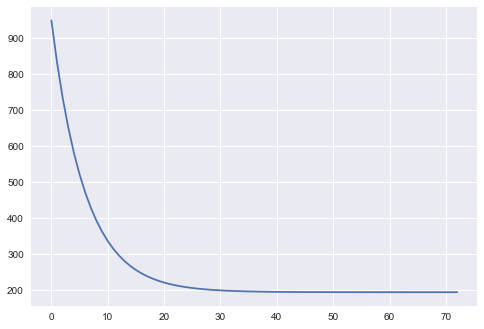

In [11]:
plt.plot(range(len(cost)), cost);

The following animation shows how the regression line forms:

In [12]:
from JSAnimation import IPython_display


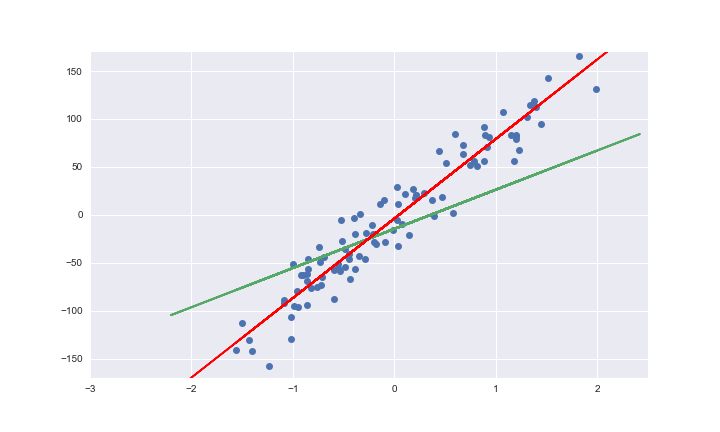
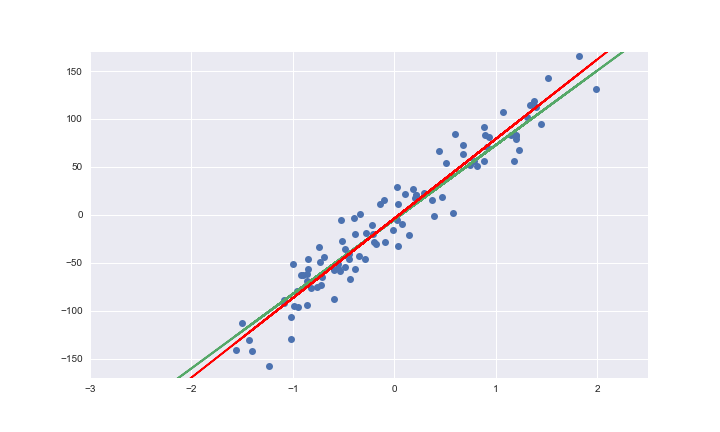
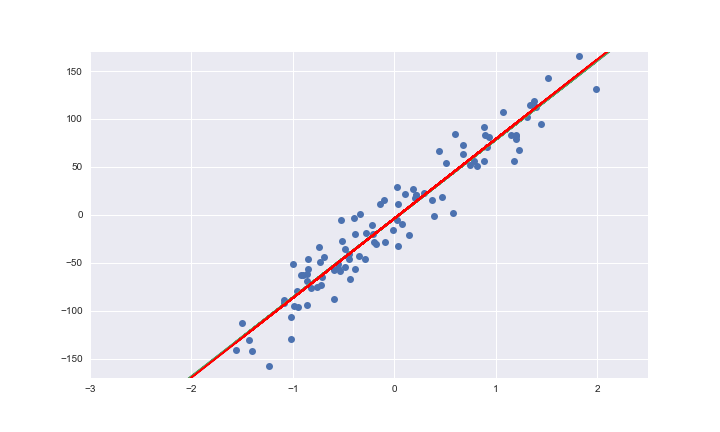

In [13]:
def init():
    line.set_data([], [])
    return line,

def animate(i):
    ys = preds[i]
    line.set_data(xaug[:, 1], ys)
    return line,



fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(-3, 2.5), ylim=(-170, 170))
ax.plot(xaug[:,1],y, 'o')
line, = ax.plot([], [], lw=2)
plt.plot(xaug[:,1], best_fit(xaug[:,1]), 'k-', color = "r")

anim = animation.FuncAnimation(fig, animate, init_func=init,
                        frames=len(preds), interval=100)
anim.save('images/gdline.mp4')
anim

Remember that the linear regression cost function is convex, and more precisely quadratic. We can see the path that gradient descent takes in arriving at the optimum:

In [14]:
from mpl_toolkits.mplot3d import Axes3D

def error(X, Y, THETA):
    return np.sum((X.dot(THETA) - Y)**2)/(2*Y.size)

def make_3d_plot(xfinal, yfinal, zfinal, hist, cost, xaug, y):
    ms = np.linspace(xfinal - 20 , xfinal + 20, 20)
    bs = np.linspace(yfinal - 40 , yfinal + 40, 40)
    M, B = np.meshgrid(ms, bs)
    zs = np.array([error(xaug, y, theta) 
                   for theta in zip(np.ravel(M), np.ravel(B))])
    Z = zs.reshape(M.shape)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.1)
    ax.contour(M, B, Z, 20, color='b', alpha=0.5, offset=0, stride=30)
    ax.set_xlabel('Intercept')
    ax.set_ylabel('Slope')
    ax.set_zlabel('Cost')
    ax.view_init(elev=30., azim=30)
    ax.plot([xfinal], [yfinal], [zfinal] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7);
    ax.plot([t[0] for t in hist], [t[1] for t in hist], cost , markerfacecolor='b', markeredgecolor='b', marker='.', markersize=5);
    ax.plot([t[0] for t in hist], [t[1] for t in hist], 0 , alpha=0.5, markerfacecolor='r', markeredgecolor='r', marker='.', markersize=5)
    
def gd_plot(xaug, y, theta, cost, hist):
    make_3d_plot(theta[0], theta[1], cost[-1], hist, cost, xaug, y)

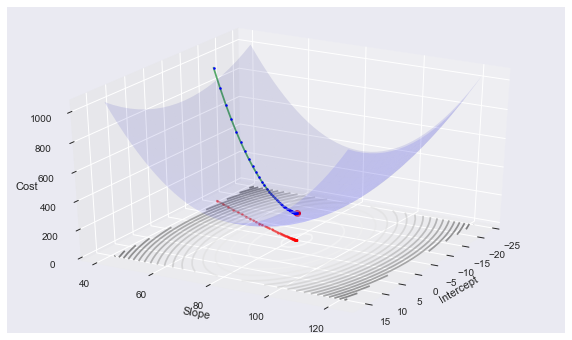

In [15]:
gd_plot(xaug, y, theta, cost, history)

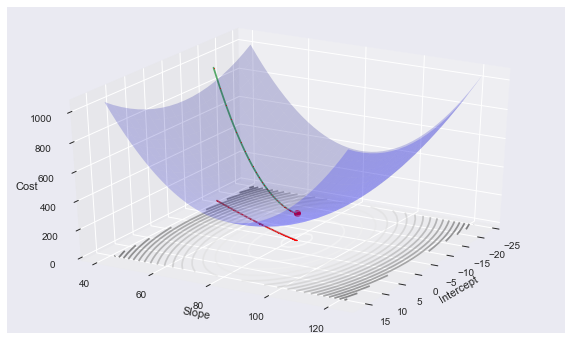

In [16]:
from mpl_toolkits.mplot3d import Axes3D

def error(X, Y, THETA):
    return np.sum((X.dot(THETA) - Y)**2)/(2*Y.size)

ms = np.linspace(theta[0] - 20 , theta[0] + 20, 20)
bs = np.linspace(theta[1] - 40 , theta[1] + 40, 40)

M, B = np.meshgrid(ms, bs)

zs = np.array([error(xaug, y, theta) 
               for theta in zip(np.ravel(M), np.ravel(B))])
Z = zs.reshape(M.shape)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.2)
ax.contour(M, B, Z, 20, color='b', alpha=0.5, offset=0, stride=30)


ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel('Cost')
ax.view_init(elev=30., azim=30)
ax.plot([theta[0]], [theta[1]], [cost[-1]] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7);
#ax.plot([history[0][0]], [history[0][1]], [cost[0]] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7);


ax.plot([t[0] for t in history], [t[1] for t in history], cost , markerfacecolor='r', markeredgecolor='r', marker='.', markersize=2);
ax.plot([t[0] for t in history], [t[1] for t in history], 0 , markerfacecolor='r', markeredgecolor='r', marker='.', markersize=2);

## Stochastic gradient descent

As noted, the gradient descent algorithm makes intuitive sense as it always proceeds in the direction of steepest descent (the gradient of $J$) and guarantees that we find a local minimum (global under certain assumptions on $J$). When we have very large data sets, however, the calculation of $\nabla (J(\theta))$ can be costly as we must process every data point before making a single step (hence the name "batch"). An alternative approach, the stochastic gradient descent method, is to update $\theta$ sequentially with every observation. The updates then take the form:

$$\theta := \theta - \alpha \nabla_{\theta} J_i(\theta)$$

This stochastic gradient approach allows us to start making progress on the minimization problem right away. It is computationally cheaper, but it results in a larger variance of the loss function in comparison with batch gradient descent. 

Generally, the stochastic gradient descent method will get close to the optimal $\theta$ much faster than the batch method, but will never fully converge to the local (or global) minimum. Thus the stochastic gradient descent method is useful when we want a quick and dirty approximation for the solution to our optimization problem. A full recipe for stochastic gradient descent follows:

- Initialize the parameter vector $\theta$ and set the learning rate $\alpha$
- Repeat until an acceptable approximation to the minimum is obtained:
    - Randomly reshuffle the instances in the training data.
    - For $i=1,2,...m$ do: $\theta := \theta - \alpha \nabla_\theta J_i(\theta)$
    
The reshuffling of the data is done to avoid a bias in the optimization algorithm by providing the data examples in a particular order. In code, the algorithm should look something like this:

```python
for i in range(nb_epochs):
  np.random.shuffle(data)
  for example in data:
    params_grad = evaluate_gradient(loss_function, example, params)
    params = params - learning_rate * params_grad
```

For a given epoch, we first reshuffle the data, and then for a single example, we evaluate the gradient of the loss function and then update the params with the chosen learning rate.

The update for linear regression is:

$$\theta_j := \theta_j + \alpha (y^{(i)}-f_\theta (x^{(i)})) x_j^{(i)}$$


In [17]:
def sgd(x, y, theta_init, step=0.001, maxsteps=0, precision=0.001, ):
    costs = []
    currentcosts = []
    m = y.size # number of data points
    oldtheta = 0
    theta = theta_init
    history = [] # to store all thetas
    preds = []
    grads = []
    xs = []
    ys = []
    counter = 0
    oldcost = 0
    epoch = 0
    i = 0 #index
    xs.append(x[i,:])
    ys.append([y[i]])
    pred = np.dot(x[i,:], theta)
    error = pred - y[i]
    gradient = x[i,:].T*error
    grads.append(gradient)
    currentcost = np.sum(error ** 2) / 2
    print("Init", gradient, x[i,:],y[i])
    print ("Init2", currentcost, theta)
    currentcosts.append(currentcost)
    counter+=1
    preds.append(pred)
    costsum = currentcost
    costs.append(costsum/counter)
    history.append(theta)
    print("start",counter, costs, oldcost)
    while 1:
        #while abs(costs[counter-1] - oldcost) > precision:
        #while np.linalg.norm(theta - oldtheta) > precision:
        gradient = x[i,:].T*error
        grads.append(gradient)
        oldtheta = theta
        theta = theta - step * gradient  # update
        history.append(theta)
        i += 1
        if i == m:#reached one past the end.
            #break
            epoch +=1
            neworder = np.random.permutation(m)
            x = x[neworder]
            y = y[neworder]
            i = 0
        xs.append(x[i,:])
        ys.append(y[i])
        pred = np.dot(x[i,:], theta)
        error = pred - y[i]
        currentcost = np.sum(error ** 2) / 2
        currentcosts.append(currentcost)
        
        #print("e/cc",error, currentcost)
        if counter % 25 == 0: preds.append(pred)
        counter+=1
        costsum += currentcost
        oldcost = costs[counter-2]
        costs.append(costsum/counter)
        #print(counter, costs, oldcost)
        if maxsteps:
            #print("in maxsteps")
            if counter == maxsteps:
                break
        
    return history, costs, preds, grads, counter, epoch, xs, ys, currentcosts

In [18]:
history2, cost2, preds2, grads2, iters2, epoch2, x2, y2, cc2 = sgd(xaug, y, theta_i, maxsteps=5000, step=0.01)


Init [-24.75520774  -0.79844029] [ 1.          0.03225343] 11.5348518902
Init2 306.410155183 [-14.53764872  40.84195039]
start 1 [306.41015518349798] 0


In [19]:
print(iters2, history2[-1], epoch2, grads2[-1])

5000 [ -3.15191155  82.514033  ] 49 [-41.75304983  22.05572989]


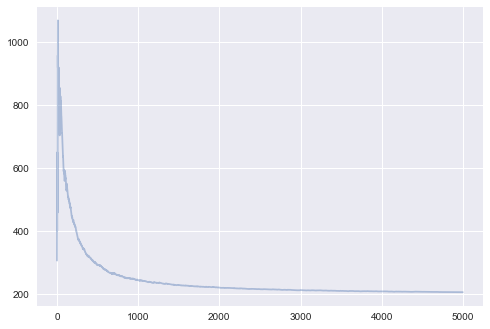

In [20]:
plt.plot(range(len(cost2[-10000:])), cost2[-10000:], alpha=0.4);

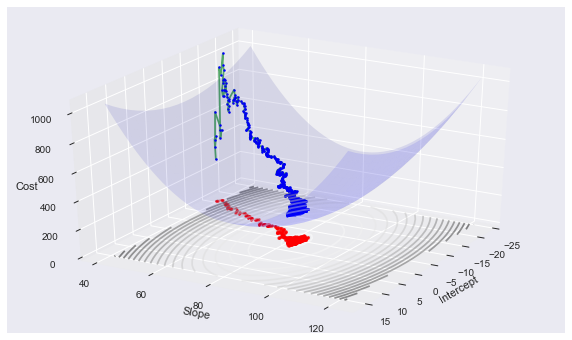

In [21]:
gd_plot(xaug, y, theta, cost2, history2)

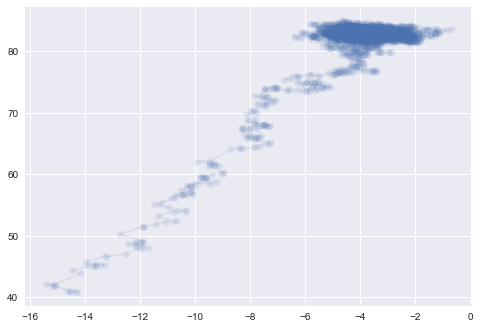

In [22]:
plt.plot([t[0] for t in history2], [t[1] for t in history2],'o-', alpha=0.1)

#### Animating SGD

Here is some code to make an animation of SGD. It shows how the risk surfaces being minimized change, and how the minimum desired is approached.

In [53]:
def error2(X, Y, THETA):
    #print("XYT", THETA, np.sum((X.dot(THETA) - Y)**2))
    return np.sum((X.dot(THETA) - Y)**2)/(2*Y.size)


def make_3d_plot2(num, it, xfinal, yfinal, zfinal, hist, cost, xaug, y):
    ms = np.linspace(xfinal - 20 , xfinal + 20, 20)
    bs = np.linspace(yfinal - 50 , yfinal + 50, 40)
    M, B = np.meshgrid(ms, bs)
    zs = np.array([error2(xaug, y, theta) 
                   for theta in zip(np.ravel(M), np.ravel(B))])
    Z = zs.reshape(M.shape)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.1)
    ax.contour(M, B, Z, 20, color='b', alpha=0.5, offset=0, stride=30)
    ax.set_xlabel('Intercept')
    ax.set_ylabel('Slope')
    ax.set_zlabel('Cost')
    ax.view_init(elev=30., azim=30)
    #print("hist", xaug, y, hist, cost)
    ax.plot([xfinal], [yfinal], [zfinal] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7);
    #ax.plot([t[0] for t in hist], [t[1] for t in hist], cost , markerfacecolor='b', markeredgecolor='b', marker='.', markersize=5);
    ax.plot([t[0] for t in hist], [t[1] for t in hist], 0 , alpha=0.5, markerfacecolor='r', markeredgecolor='r', marker='.', markersize=5)
    ax.set_zlim([0, 3000])
    plt.title("Iteration {}".format(it))
    plt.savefig("images/3danim{0:03d}.png".format(num))
    plt.close()

In [54]:
print("fthetas",theta[0], theta[1], "len", len(history2))
ST = list(range(0, 750, 10)) + list(range(750, 5000, 250))
len(ST)

fthetas -3.72552265122 82.7970526876 len 5000


92

In [55]:
for i in range(len(ST)):
    #print(history2[i*ST[i]], cc2[i*ST[i]])
    make_3d_plot2(i, ST[i], theta[0], theta[1], cost2[-1], [history2[ST[i]]], [cc2[ST[i]]], np.array([x2[ST[i]]]), np.array([y2[ST[i]]]))

Using Imagemagick we can produce a gif animation:
(`convert -delay 20 -loop 1 3danim*.png animsgd.gif`)

(I set this animation to repeat just once. (`loop 1`). Reload this cell to see it again. On the web page right clicking the image might allow for an option to loop again)

![](images/animsgd.gif)

## Mini-batch gradient descent
What if instead of single example from the dataset, we use a batch of data examples witha given size every time we calculate the gradient:

$$\theta = \theta - \eta \nabla_{\theta} J(\theta; x^{(i:i+n)}; y^{(i:i+n)})$$

This is what mini-batch gradient descent is about. Using mini-batches has the advantage that the variance in the loss function is reduced, while the computational burden is still reasonable, since we do not use the full dataset. The size of the mini-batches becomes another hyper-parameter of the problem. In standard implementations it ranges from 50 to 256. In code, mini-batch gradient descent looks like this:

```python
for i in range(mb_epochs):
  np.random.shuffle(data)
  for batch in get_batches(data, batch_size=50):
    params_grad = evaluate_gradient(loss_function, batch, params)
    params = params - learning_rate * params_grad
```

The difference with SGD is that for each update we use a batch of 50 examples to estimate the gradient.

## Variations on a theme

### Momentum

Often, the cost function has ravines near local optima, ie. areas where the shape of the function is significantly steeper in certain dimensions than in others. This migh result in a slow convergence to the optimum, since standard gradient descent will keep oscillating about these ravines. In the figures below, the left panel shows convergence without momentum, and the right panel shows the effect of adding momentum:

<table><tr><td><img src="http://sebastianruder.com/content/images/2015/12/without_momentum.gif", width=300, height=300></td><td><img src="http://sebastianruder.com/content/images/2015/12/with_momentum.gif", width=300, height=300></td></tr></table>

One way to overcome this problem is by using the concept of momentum, which is borrowed from physics. At each iteration, we remember the update $v = \Delta \theta$ and use this *velocity* vector (which as the same dimension as $\theta$) in the next update, which is constructed as a combination of the cost gradient and the previous update:

$$v_t = \gamma v_{t-1} +  \eta \nabla_{\theta} J(\theta)$$
$$\theta = \theta - v_t$$

The effect of this is the following: the momentum terms increases for dimensions whose gradients point in the same direction, and reduces the importance of dimensions whose gradients change direction. This avoids oscillations and improves the chances of rapid convergence. The concept is analog to the  a rock rolling down a hill: the gravitational field (cost function) accelerates the particule (weights vector), which accumulates momentum, becomes faster and faster and tends to keep travelling in the same direction. A commonly used value for the momentum parameter is $\gamma = 0.5$.